## Import and Install Dependencies

In [1]:
#!pip install tensorflow opencv-python mediapipe scikit-learn matplotlib

In [2]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

## Capture Keypoints using Media Holistic

In [3]:
holistic_mp = mp.solutions.holistic # Holistic model (to make detections)
drawing_mp = mp.solutions.drawing_utils # Drawing utilities (draw the keypoints)

In [4]:
# Function to detect actions
def mp_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  
    results = model.process(image)                 
    image.flags.writeable = True                  
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

The holistic model gives a connection map of our body, which is then passed into the below function.

In [5]:
def draw_landmarks_styled(image, results):
    # Draw face connections
    drawing_mp.draw_landmarks(image, results.face_landmarks, holistic_mp.FACEMESH_TESSELATION,
                             drawing_mp.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                             drawing_mp.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             )
    # Draw pose connections
    drawing_mp.draw_landmarks(image, results.pose_landmarks, holistic_mp.POSE_CONNECTIONS,
                             drawing_mp.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             drawing_mp.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    drawing_mp.draw_landmarks(image, results.left_hand_landmarks, holistic_mp.HAND_CONNECTIONS, 
                             drawing_mp.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             drawing_mp.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    drawing_mp.draw_landmarks(image, results.right_hand_landmarks, holistic_mp.HAND_CONNECTIONS, 
                             drawing_mp.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             drawing_mp.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [6]:
# Check to see if opencv captures video

video = cv2.VideoCapture(0)

with holistic_mp.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

    while video.isOpened():
        ret, frame = video.read()

        # Make Detection
        image, results = mp_detection(frame, holistic)
        print(results)
        
        # len(results.pose_landmarks.landmark) # Converts to a list, just to check the landmarks array
        # Draw landmarks
        draw_landmarks_styled(image, results)

        # Show to screen; showing the video to user
        cv2.imshow('OpenCV Feed', image)

        # Break once escape
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
            
    video.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [7]:
draw_landmarks_styled(frame, results)

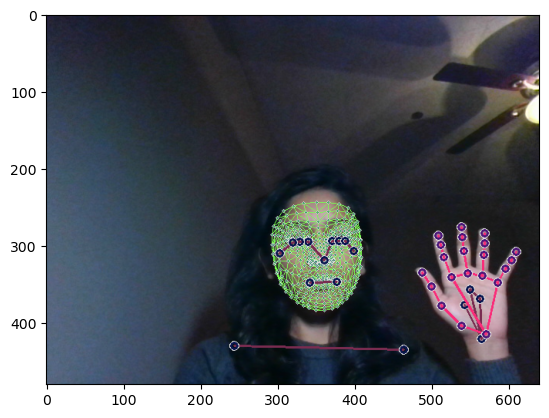

In [8]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

## Extract Captured Keypoints

In [6]:
def extract_keypoints(results):
    # Returns a flat array of all landmarks
    pose_keypoints = np.array([[pose.x, pose.y, pose.z, pose.visibility] for pose in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face_keypoints = np.array([[face.x, face.y, face.z] for face in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh_keypoints = np.array([[left.x, left.y, left.z] for left in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh_keypoints =  np.array([[right.x, right.y, right.z] for right in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose_keypoints, face_keypoints, lh_keypoints, rh_keypoints])

## Setup Folders for Collection

In [7]:
# Path for exported data, numpy arrays

DATA_PATH = os.path.join('Data_MP') 

# Actions that we try to detect
actions = np.array(['hello', 'thanks', 'iloveyou', 'happy'])

# Thirty videos worth of data
sequences_no = 30

# Videos are going to be 30 frames in length
sequence_length = 30

Each directory will contain a single video

In [16]:
for action in actions: 
    for sequence in range(sequences_no):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

## Collect Training & Testing Data (Keypoints from Videos)

In [17]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with holistic_mp.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(sequences_no):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mp_detection(frame, holistic)
#                 print(results)

                # Draw landmarks
                draw_landmarks_styled(image, results)
                
                # Apply wait logic so that there is time to change the signs
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

## Preprocess Data and Create Labels & Features

In [8]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [9]:
label_map = {label:num for num, label in enumerate(actions)}

In [10]:
sequences, labels = [], []
for action in actions:
    for sequence in range(sequences_no):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [11]:
# np.array(sequences).shape  (120, 30, 1662)
# np.array(labels).shape (120,)

In [12]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# X_train, y_train are for training, X_val, y_val are for validation, and X_test, y_test are for testing

In [14]:
X_train.shape

(96, 30, 1662)

In [15]:
X_test.shape

(12, 30, 1662)

In [16]:
X_val.shape

(12, 30, 1662)

In [17]:
y_train.shape
# y_test.shape

(96, 4)

## Build & Train LSTM Neural Network

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [19]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [20]:
# Define the range of epochs to try
epochs_to_try = [100, 150, 200, 300, 500, 1000]
best_model = None
best_val_accuracy = 0
best_epoch = 0

# Loop through different epoch numbers
for num_epochs in epochs_to_try:
    model = Sequential()
    model.add(LSTM(64, return_sequences = True, activation = 'relu', input_shape = (30, 1662)))
    model.add(LSTM(128, return_sequences = True, activation = 'relu', input_shape = (30, 1662)))
    model.add(LSTM(64, return_sequences = False, activation = 'relu', input_shape = (30, 1662)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(actions.shape[0], activation='softmax'))

    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    model.fit(X_train, y_train, epochs=num_epochs, callbacks=[tb_callback])

    # Evaluate the model on the validation set
    val_loss, val_accuracy = model.evaluate(X_val, y_val)
    
    # Choose the best model based on validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model = model
        best_epoch = num_epochs




Epoch 1/100


3/3 [==============================] - 5s 63ms/step - loss: 11.2842 - categorical_accuracy: 0.2604
Epoch 2/100
3/3 [==============================] - 0s 56ms/step - loss: 12.5256 - categorical_accuracy: 0.2396
Epoch 3/100
3/3 [==============================] - 0s 54ms/step - loss: 11.4684 - categorical_accuracy: 0.2604
Epoch 4/100
3/3 [==============================] - 0s 54ms/step - loss: 12.3772 - categorical_accuracy: 0.2396
Epoch 5/100
3/3 [==============================] - 0s 46ms/step - loss: 21.6870 - categorical_accuracy: 0.1146
Epoch 6/100
3/3 [==============================] - 0s 50ms/step - loss: 10.8785 - categorical_accuracy: 0.2917
Epoch 7/100
3/3 [==============================] - 0s 50ms/step - loss: 17.3781 - categorical_accuracy: 0.3125
Epoch 8/100
3/3 [==============================] - 0s 48ms/step - loss: 11.5130 - categorical_accuracy: 0.2500
Epoch 9/100
3/3 [==============================] - 0s 46ms/step - loss: 10.5009 - categorical_accuracy: 0.20

3/3 [==============================] - 0s 50ms/step - loss: 0.3571 - categorical_accuracy: 0.8438
Epoch 40/150
3/3 [==============================] - 0s 63ms/step - loss: 0.3025 - categorical_accuracy: 0.9375
Epoch 41/150
3/3 [==============================] - 0s 68ms/step - loss: 0.2590 - categorical_accuracy: 0.9271
Epoch 42/150
3/3 [==============================] - 0s 47ms/step - loss: 0.2192 - categorical_accuracy: 0.8854
Epoch 43/150
3/3 [==============================] - 0s 45ms/step - loss: 0.1712 - categorical_accuracy: 0.9167
Epoch 44/150
3/3 [==============================] - 0s 58ms/step - loss: 0.2295 - categorical_accuracy: 0.9375
Epoch 45/150
3/3 [==============================] - 0s 54ms/step - loss: 0.1352 - categorical_accuracy: 0.9583
Epoch 46/150
3/3 [==============================] - 0s 46ms/step - loss: 0.1244 - categorical_accuracy: 0.9688
Epoch 47/150
3/3 [==============================] - 0s 50ms/step - loss: 0.6300 - categorical_accuracy: 0.7812
Epoch 48/150
3

3/3 [==============================] - 0s 46ms/step - loss: 44.5201 - categorical_accuracy: 0.3125
Epoch 35/200
3/3 [==============================] - 0s 50ms/step - loss: 42.7587 - categorical_accuracy: 0.2708
Epoch 36/200
3/3 [==============================] - 0s 54ms/step - loss: 51.6767 - categorical_accuracy: 0.2188
Epoch 37/200
3/3 [==============================] - 0s 49ms/step - loss: 48.9158 - categorical_accuracy: 0.2292
Epoch 38/200
3/3 [==============================] - 0s 53ms/step - loss: 56.5365 - categorical_accuracy: 0.2292
Epoch 39/200
3/3 [==============================] - 0s 43ms/step - loss: 35.6320 - categorical_accuracy: 0.2812
Epoch 40/200
3/3 [==============================] - 0s 47ms/step - loss: 11.6637 - categorical_accuracy: 0.3021
Epoch 41/200
3/3 [==============================] - 0s 58ms/step - loss: 23.7777 - categorical_accuracy: 0.2604
Epoch 42/200
3/3 [==============================] - 0s 45ms/step - loss: 22.7425 - categorical_accuracy: 0.2917
Epoch

3/3 [==============================] - 0s 43ms/step - loss: 0.7376 - categorical_accuracy: 0.5938
Epoch 181/200
3/3 [==============================] - 0s 44ms/step - loss: 0.7270 - categorical_accuracy: 0.5938
Epoch 182/200
3/3 [==============================] - 0s 49ms/step - loss: 0.7578 - categorical_accuracy: 0.6146
Epoch 183/200
3/3 [==============================] - 0s 49ms/step - loss: 0.7235 - categorical_accuracy: 0.6250
Epoch 184/200
3/3 [==============================] - 0s 51ms/step - loss: 0.7349 - categorical_accuracy: 0.6562
Epoch 185/200
3/3 [==============================] - 0s 50ms/step - loss: 0.7343 - categorical_accuracy: 0.6250
Epoch 186/200
3/3 [==============================] - 0s 50ms/step - loss: 0.7438 - categorical_accuracy: 0.5938
Epoch 187/200
3/3 [==============================] - 0s 44ms/step - loss: 0.7151 - categorical_accuracy: 0.6458
Epoch 188/200
3/3 [==============================] - 0s 48ms/step - loss: 0.7400 - categorical_accuracy: 0.6250
Epoch 

3/3 [==============================] - 0s 46ms/step - loss: 1.3682 - categorical_accuracy: 0.2500
Epoch 126/300
3/3 [==============================] - 0s 47ms/step - loss: 1.2949 - categorical_accuracy: 0.3229
Epoch 127/300
3/3 [==============================] - 0s 46ms/step - loss: 1.3416 - categorical_accuracy: 0.2917
Epoch 128/300
3/3 [==============================] - 0s 41ms/step - loss: 4.5621 - categorical_accuracy: 0.4375
Epoch 129/300
3/3 [==============================] - 0s 44ms/step - loss: 1.4232 - categorical_accuracy: 0.2604
Epoch 130/300
3/3 [==============================] - 0s 48ms/step - loss: 1.4281 - categorical_accuracy: 0.2604
Epoch 131/300
3/3 [==============================] - 0s 47ms/step - loss: 1.4219 - categorical_accuracy: 0.2604
Epoch 132/300
3/3 [==============================] - 0s 49ms/step - loss: 1.4152 - categorical_accuracy: 0.2604
Epoch 133/300
3/3 [==============================] - 0s 43ms/step - loss: 1.4032 - categorical_accuracy: 0.2604
Epoch 

3/3 [==============================] - 0s 51ms/step - loss: 1.3700 - categorical_accuracy: 0.2812
Epoch 272/300
3/3 [==============================] - 0s 52ms/step - loss: 1.3701 - categorical_accuracy: 0.2812
Epoch 273/300
3/3 [==============================] - 0s 55ms/step - loss: 1.3702 - categorical_accuracy: 0.2812
Epoch 274/300
3/3 [==============================] - 0s 51ms/step - loss: 1.3700 - categorical_accuracy: 0.2812
Epoch 275/300
3/3 [==============================] - 0s 51ms/step - loss: 1.3700 - categorical_accuracy: 0.2812
Epoch 276/300
3/3 [==============================] - 0s 58ms/step - loss: 1.3700 - categorical_accuracy: 0.2812
Epoch 277/300
3/3 [==============================] - 0s 56ms/step - loss: 1.3700 - categorical_accuracy: 0.2812
Epoch 278/300
3/3 [==============================] - 0s 49ms/step - loss: 1.3700 - categorical_accuracy: 0.2812
Epoch 279/300
3/3 [==============================] - 0s 58ms/step - loss: 1.3700 - categorical_accuracy: 0.2812
Epoch 

3/3 [==============================] - 0s 52ms/step - loss: 0.2080 - categorical_accuracy: 0.9375
Epoch 117/500
3/3 [==============================] - 0s 52ms/step - loss: 0.1707 - categorical_accuracy: 0.9479
Epoch 118/500
3/3 [==============================] - 0s 47ms/step - loss: 0.1426 - categorical_accuracy: 0.9583
Epoch 119/500
3/3 [==============================] - 0s 47ms/step - loss: 0.1330 - categorical_accuracy: 0.9479
Epoch 120/500
3/3 [==============================] - 0s 48ms/step - loss: 0.1185 - categorical_accuracy: 0.9479
Epoch 121/500
3/3 [==============================] - 0s 64ms/step - loss: 0.1038 - categorical_accuracy: 0.9688
Epoch 122/500
3/3 [==============================] - 0s 64ms/step - loss: 0.1104 - categorical_accuracy: 0.9688
Epoch 123/500
3/3 [==============================] - 0s 58ms/step - loss: 0.1117 - categorical_accuracy: 0.9688
Epoch 124/500
3/3 [==============================] - 0s 46ms/step - loss: 0.0871 - categorical_accuracy: 0.9688
Epoch 

3/3 [==============================] - 0s 50ms/step - loss: 1.0434e-04 - categorical_accuracy: 1.0000
Epoch 261/500
3/3 [==============================] - 0s 54ms/step - loss: 1.0275e-04 - categorical_accuracy: 1.0000
Epoch 262/500
3/3 [==============================] - 0s 50ms/step - loss: 1.0100e-04 - categorical_accuracy: 1.0000
Epoch 263/500
3/3 [==============================] - 0s 53ms/step - loss: 9.9564e-05 - categorical_accuracy: 1.0000
Epoch 264/500
3/3 [==============================] - 0s 47ms/step - loss: 9.7931e-05 - categorical_accuracy: 1.0000
Epoch 265/500
3/3 [==============================] - 0s 47ms/step - loss: 9.6498e-05 - categorical_accuracy: 1.0000
Epoch 266/500
3/3 [==============================] - 0s 47ms/step - loss: 9.4872e-05 - categorical_accuracy: 1.0000
Epoch 267/500
3/3 [==============================] - 0s 56ms/step - loss: 9.3582e-05 - categorical_accuracy: 1.0000
Epoch 268/500
3/3 [==============================] - 0s 52ms/step - loss: 9.2160e-05 -

3/3 [==============================] - 0s 43ms/step - loss: 1.5947e-05 - categorical_accuracy: 1.0000
Epoch 401/500
3/3 [==============================] - 0s 50ms/step - loss: 1.5749e-05 - categorical_accuracy: 1.0000
Epoch 402/500
3/3 [==============================] - 0s 45ms/step - loss: 1.5593e-05 - categorical_accuracy: 1.0000
Epoch 403/500
3/3 [==============================] - 0s 41ms/step - loss: 1.5411e-05 - categorical_accuracy: 1.0000
Epoch 404/500
3/3 [==============================] - 0s 44ms/step - loss: 1.5256e-05 - categorical_accuracy: 1.0000
Epoch 405/500
3/3 [==============================] - 0s 47ms/step - loss: 1.5071e-05 - categorical_accuracy: 1.0000
Epoch 406/500
3/3 [==============================] - 0s 48ms/step - loss: 1.4917e-05 - categorical_accuracy: 1.0000
Epoch 407/500
3/3 [==============================] - 0s 46ms/step - loss: 1.4735e-05 - categorical_accuracy: 1.0000
Epoch 408/500
3/3 [==============================] - 0s 48ms/step - loss: 1.4583e-05 -

3/3 [==============================] - 0s 49ms/step - loss: 0.7441 - categorical_accuracy: 0.6875
Epoch 36/1000
3/3 [==============================] - 0s 48ms/step - loss: 0.7619 - categorical_accuracy: 0.6875
Epoch 37/1000
3/3 [==============================] - 0s 40ms/step - loss: 0.7632 - categorical_accuracy: 0.6354
Epoch 38/1000
3/3 [==============================] - 0s 49ms/step - loss: 0.7424 - categorical_accuracy: 0.7083
Epoch 39/1000
3/3 [==============================] - 0s 48ms/step - loss: 0.7326 - categorical_accuracy: 0.6458
Epoch 40/1000
3/3 [==============================] - 0s 54ms/step - loss: 0.7373 - categorical_accuracy: 0.6562
Epoch 41/1000
3/3 [==============================] - 0s 48ms/step - loss: 0.7477 - categorical_accuracy: 0.6771
Epoch 42/1000
3/3 [==============================] - 0s 45ms/step - loss: 0.9508 - categorical_accuracy: 0.5625
Epoch 43/1000
3/3 [==============================] - 0s 50ms/step - loss: 3.3117 - categorical_accuracy: 0.2500
Epoch 

3/3 [==============================] - 0s 48ms/step - loss: 0.3828 - categorical_accuracy: 0.8854
Epoch 181/1000
3/3 [==============================] - 0s 39ms/step - loss: 0.3644 - categorical_accuracy: 0.9062
Epoch 182/1000
3/3 [==============================] - 0s 41ms/step - loss: 0.3509 - categorical_accuracy: 0.9167
Epoch 183/1000
3/3 [==============================] - 0s 41ms/step - loss: 0.5137 - categorical_accuracy: 0.7500
Epoch 184/1000
3/3 [==============================] - 0s 44ms/step - loss: 0.6146 - categorical_accuracy: 0.6875
Epoch 185/1000
3/3 [==============================] - 0s 45ms/step - loss: 0.6923 - categorical_accuracy: 0.6250
Epoch 186/1000
3/3 [==============================] - 0s 42ms/step - loss: 0.5576 - categorical_accuracy: 0.7708
Epoch 187/1000
3/3 [==============================] - 0s 50ms/step - loss: 0.6119 - categorical_accuracy: 0.6979
Epoch 188/1000
3/3 [==============================] - 0s 44ms/step - loss: 0.8044 - categorical_accuracy: 0.697

3/3 [==============================] - 0s 48ms/step - loss: 0.5280 - categorical_accuracy: 0.8229
Epoch 325/1000
3/3 [==============================] - 0s 42ms/step - loss: 0.7150 - categorical_accuracy: 0.7500
Epoch 326/1000
3/3 [==============================] - 0s 44ms/step - loss: 0.5324 - categorical_accuracy: 0.8229
Epoch 327/1000
3/3 [==============================] - 0s 49ms/step - loss: 0.4321 - categorical_accuracy: 0.8125
Epoch 328/1000
3/3 [==============================] - 0s 48ms/step - loss: 0.4628 - categorical_accuracy: 0.8333
Epoch 329/1000
3/3 [==============================] - 0s 46ms/step - loss: 0.4115 - categorical_accuracy: 0.8958
Epoch 330/1000
3/3 [==============================] - 0s 48ms/step - loss: 0.3112 - categorical_accuracy: 0.9271
Epoch 331/1000
3/3 [==============================] - 0s 48ms/step - loss: 0.3239 - categorical_accuracy: 0.9062
Epoch 332/1000
3/3 [==============================] - 0s 44ms/step - loss: 1.6645 - categorical_accuracy: 0.708

3/3 [==============================] - 0s 45ms/step - loss: 0.1101 - categorical_accuracy: 0.9792
Epoch 469/1000
3/3 [==============================] - 0s 47ms/step - loss: 0.1193 - categorical_accuracy: 0.9688
Epoch 470/1000
3/3 [==============================] - 0s 45ms/step - loss: 0.1116 - categorical_accuracy: 0.9688
Epoch 471/1000
3/3 [==============================] - 0s 45ms/step - loss: 0.0977 - categorical_accuracy: 0.9792
Epoch 472/1000
3/3 [==============================] - 0s 48ms/step - loss: 0.1044 - categorical_accuracy: 0.9792
Epoch 473/1000
3/3 [==============================] - 0s 45ms/step - loss: 0.1011 - categorical_accuracy: 0.9792
Epoch 474/1000
3/3 [==============================] - 0s 48ms/step - loss: 0.0991 - categorical_accuracy: 0.9792
Epoch 475/1000
3/3 [==============================] - 0s 44ms/step - loss: 0.0960 - categorical_accuracy: 0.9792
Epoch 476/1000
3/3 [==============================] - 0s 44ms/step - loss: 0.1005 - categorical_accuracy: 0.979

3/3 [==============================] - 0s 53ms/step - loss: 0.0912 - categorical_accuracy: 0.9583
Epoch 613/1000
3/3 [==============================] - 0s 52ms/step - loss: 0.0901 - categorical_accuracy: 0.9688
Epoch 614/1000
3/3 [==============================] - 0s 49ms/step - loss: 0.0832 - categorical_accuracy: 0.9688
Epoch 615/1000
3/3 [==============================] - 0s 48ms/step - loss: 0.0877 - categorical_accuracy: 0.9688
Epoch 616/1000
3/3 [==============================] - 0s 50ms/step - loss: 0.0821 - categorical_accuracy: 0.9688
Epoch 617/1000
3/3 [==============================] - 0s 50ms/step - loss: 0.0873 - categorical_accuracy: 0.9688
Epoch 618/1000
3/3 [==============================] - 0s 49ms/step - loss: 0.0879 - categorical_accuracy: 0.9688
Epoch 619/1000
3/3 [==============================] - 0s 53ms/step - loss: 0.0821 - categorical_accuracy: 0.9688
Epoch 620/1000
3/3 [==============================] - 0s 53ms/step - loss: 0.0946 - categorical_accuracy: 0.968

3/3 [==============================] - 0s 49ms/step - loss: 0.0021 - categorical_accuracy: 1.0000
Epoch 757/1000
3/3 [==============================] - 0s 48ms/step - loss: 0.0020 - categorical_accuracy: 1.0000
Epoch 758/1000
3/3 [==============================] - 0s 48ms/step - loss: 0.0019 - categorical_accuracy: 1.0000
Epoch 759/1000
3/3 [==============================] - 0s 48ms/step - loss: 0.0018 - categorical_accuracy: 1.0000
Epoch 760/1000
3/3 [==============================] - 0s 53ms/step - loss: 0.0017 - categorical_accuracy: 1.0000
Epoch 761/1000
3/3 [==============================] - 0s 47ms/step - loss: 0.0017 - categorical_accuracy: 1.0000
Epoch 762/1000
3/3 [==============================] - 0s 46ms/step - loss: 0.0016 - categorical_accuracy: 1.0000
Epoch 763/1000
3/3 [==============================] - 0s 43ms/step - loss: 0.0016 - categorical_accuracy: 1.0000
Epoch 764/1000
3/3 [==============================] - 0s 50ms/step - loss: 0.0015 - categorical_accuracy: 1.000

3/3 [==============================] - 0s 60ms/step - loss: 3.4660e-04 - categorical_accuracy: 1.0000
Epoch 897/1000
3/3 [==============================] - 0s 60ms/step - loss: 3.4398e-04 - categorical_accuracy: 1.0000
Epoch 898/1000
3/3 [==============================] - 0s 59ms/step - loss: 3.4222e-04 - categorical_accuracy: 1.0000
Epoch 899/1000
3/3 [==============================] - 0s 51ms/step - loss: 3.4013e-04 - categorical_accuracy: 1.0000
Epoch 900/1000
3/3 [==============================] - 0s 59ms/step - loss: 3.3788e-04 - categorical_accuracy: 1.0000
Epoch 901/1000
3/3 [==============================] - 0s 51ms/step - loss: 3.3569e-04 - categorical_accuracy: 1.0000
Epoch 902/1000
3/3 [==============================] - 0s 56ms/step - loss: 3.3407e-04 - categorical_accuracy: 1.0000
Epoch 903/1000
3/3 [==============================] - 0s 59ms/step - loss: 3.3248e-04 - categorical_accuracy: 1.0000
Epoch 904/1000
3/3 [==============================] - 0s 63ms/step - loss: 3.30

In [21]:
best_val_accuracy

1.0

In [22]:
best_epoch

500

In [23]:
best_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 30, 64)            442112    
                                                                 
 lstm_13 (LSTM)              (None, 30, 128)           98816     
                                                                 
 lstm_14 (LSTM)              (None, 64)                49408     
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 4)                 132       
                                                                 
Total params: 596708 (2.28 MB)
Trainable params: 59670

## Make Predictions

In [24]:
res = best_model.predict(X_test)

1/1 [==============================] - 0s 389ms/step


In [25]:
actions[np.argmax(res[2])]

'thanks'

In [26]:
actions[np.argmax(y_test[2])]

'thanks'

## Save weights of Model

In [27]:
best_model.save('sign_lang_model.keras')

## Model Evaluation

In [29]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [30]:
yhat = best_model.predict(X_test)

1/1 [==============================] - 0s 40ms/step


In [31]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [32]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[10,  0],
        [ 0,  2]],

       [[ 7,  0],
        [ 1,  4]],

       [[ 9,  0],
        [ 0,  3]],

       [[ 9,  1],
        [ 0,  2]]], dtype=int64)

In [33]:
accuracy_score(ytrue, yhat)

0.9166666666666666

## Test In Realtime

In [44]:
colors = [(245,117,16), (117,245,16), (16,117,245), (50, 200, 150)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [46]:
sequence = []
sentence = []
threshold = 0.8

cap = cv2.VideoCapture(0)
with holistic_mp.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        ret, frame = cap.read()

        image, results = mp_detection(frame, holistic)
        print(results)
        
        draw_landmarks_styled(image, results)
        
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = best_model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 7: 
                sentence = sentence[-7:]

            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        cv2.imshow('OpenCV Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

1/1 [==============================] - 0s 21ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 23ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 23ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 27ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 23ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 24ms/step
ilov

1/1 [==============================] - 0s 13ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 28ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 38ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 26ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 23ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 28ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 23ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
hello
<class 'mediapipe.pyth

1/1 [==============================] - 0s 24ms/step
happy
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
happy
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 24ms/step
happy
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 29ms/step
happy
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 27ms/step
happy
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
happy
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
happy
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
happy
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 38ms/step
happy
<class 'mediapipe.pyth

1/1 [==============================] - 0s 26ms/step
happy
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 24ms/step
happy
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 23ms/step
happy
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 26ms/step
happy
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 30ms/step
happy
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
happy
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
happy
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 23ms/step
happy
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 26ms/step
happy
<class 'mediapipe.pyth

1/1 [==============================] - 0s 26ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 30ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 29ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 30ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 24ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 23ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 27ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 26ms/step
ilov

iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 27ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 29ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 32ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 30ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 23ms/step
iloveyou
<class 'mediapipe.python.solution_base.Solution

1/1 [==============================] - 0s 25ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 28ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 14ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 24ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 24ms/step
ilov

1/1 [==============================] - 0s 20ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 12ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 23ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 23ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 26ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
ilov